In [1]:
# libraries used
import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from diff_predictor import core, data_process, predxgboost, spatial

#from diff_predictor import spatial
from matplotlib import colors as plt_colors

#import altair as alt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing

from sklearn.linear_model import RidgeClassifier

from group_lasso import GroupLasso, LogisticGroupLasso
import shap

Using current directory for loading/saving: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor/notebooks
To change current directory, call change_dir(...)


In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor/notebooks
Using current directory for loading data: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor


In [28]:
dataset_path = workbookDir + '/data/features_ecm/'
#msd_path = workbookDir + '/nlsschim/raw_data_pnn/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'feat' in f]
#msd_filelist = [f for f in listdir(msd_path) if isfile(join(msd_path, f)) and 'msd' in f]
#print(len(msd_filelist))
print(len(filelist))

180


In [29]:
fstats_tot = data_process.generate_fullstats(dataset_path, filelist, ['ChABC', 'NT'], 'Treatment')

ChABC
Adding file features_ChABC_brain_1_slice_1_vid_1.csv size: (502, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_1_vid_2.csv size: (1734, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_1_vid_3.csv size: (593, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_1_vid_4.csv size: (258, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_1_vid_5.csv size: (888, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_2_vid_1.csv size: (1350, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_2_vid_2.csv size: (690, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_2_vid_3.csv size: (1257, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_2_vid_4.csv size: (1070, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_2_vid_5.csv size: (1097, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_3_vid_1.csv size: (1141, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_3_vid_2.csv size: (1307, 67)
NT
ChABC
Adding file features_ChABC_brain_1_slice_3_vid_3.cs

ChABC
NT
Adding file features_NT_brain_3_slice_3_vid_2.csv size: (378, 67)
ChABC
NT
Adding file features_NT_brain_3_slice_3_vid_3.csv size: (434, 67)
ChABC
NT
Adding file features_NT_brain_3_slice_3_vid_4.csv size: (515, 67)
ChABC
NT
Adding file features_NT_brain_3_slice_3_vid_5.csv size: (493, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_1_vid_1.csv size: (780, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_1_vid_2.csv size: (648, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_1_vid_3.csv size: (294, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_1_vid_4.csv size: (526, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_1_vid_5.csv size: (624, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_2_vid_1.csv size: (381, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_2_vid_2.csv size: (1195, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_2_vid_3.csv size: (432, 67)
ChABC
NT
Adding file features_NT_brain_4_slice_2_vid_4.csv size: (700, 67)
ChABC
NT
Adding file fea

In [34]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    #'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
#     'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    'Mean Deff2',
    'X',
    'Y',
    'Treatment'
]

target = 'Treatment'

ecm = fstats_tot[columns]#.drop(['Deff2', 'Mean Deff2', 'Std Deff2'], axis=1) # Removing since 97% is null
#ecm['Treatment'] = fstats_tot['Treatment'].values
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points

In [35]:
ecm.shape

(32150, 34)

In [36]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (ChABC:NT) = 11507:20643
Ratio after balance (ChABC:NT) = 11507:11507


In [37]:
label_df = bal_ecm['Treatment']
features_df = bal_ecm.drop(['Treatment', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

In [38]:
features

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Mean alpha',
       'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1', 'Mean asymmetry2',
       'Mean asymmetry3', 'Mean AR', 'Mean elongation', 'Mean boundedness',
       'Mean fractal_dim', 'Mean trappedness', 'Mean efficiency',
       'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1', 'Mean Deff2'],
      dtype='object')

In [39]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.8
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
#X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test_val['encoded_target']
#y_val = X_val['encoded_target']
#
# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]



In [40]:
X = X_train[features]
y = y_train

In [41]:
clf = RidgeClassifier(normalize=True).fit(X_train[features], y_train)
clf.score(X_train[features], y_train)

0.6791941947362721

In [42]:
clf.score(X_test_val[features], y_test)

0.6726033421284081

In [23]:
clf.get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': True,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [26]:
y.shape

(102537,)

AttributeError: 'list' object has no attribute 'shape'

Ill-conditioned matrix (rcond=6.19853e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19858e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19864e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19871e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.1988e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19891e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19905e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19923e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19946e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.19975e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.20011e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.20056e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.20114e-35): result may not be accurate.
Ill-conditioned matrix (rcond=6.20187e-35): result may not be acc

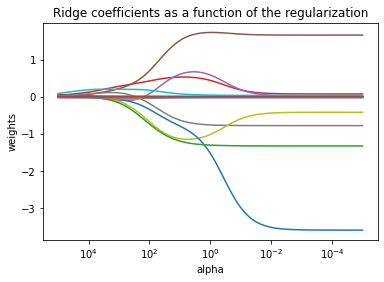

In [27]:
n_alphas = 100
alphas = np.logspace(-5, 5, n_alphas)

clf_coefs = []
for a in alphas:
    clf = RidgeClassifier(alpha=a, fit_intercept=False, normalize=True)
    clf.fit(X_train[features], y_train)
    clf_coefs.append(clf.coef_[0])

# #############################################################################
# Display results

ax = plt.gca()


ax.plot(alphas, clf_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Automatically created module for IPython interactive environment
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)

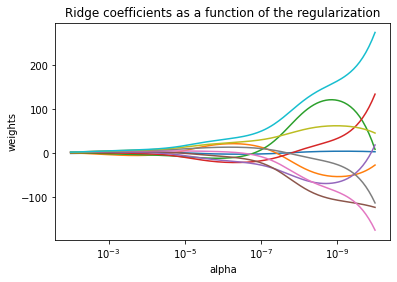

In [32]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    print(ridge.coef_.shape)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Implemnting Group Lasso

In [24]:
GroupLasso.LOG_LOSSES = True

In [43]:
features

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Mean alpha',
       'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1', 'Mean asymmetry2',
       'Mean asymmetry3', 'Mean AR', 'Mean elongation', 'Mean boundedness',
       'Mean fractal_dim', 'Mean trappedness', 'Mean efficiency',
       'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1', 'Mean Deff2'],
      dtype='object')

Grouping based off of PCA bi-plot
- Todo: add image of biplot

In [128]:
feat_groups = {
    'alpha': 4, 
    'D_fit': 3, 
    'kurtosis': 2, 
    'asymmetry1': 1, 
    'asymmetry2': 3, 
    'asymmetry3': 1,
    'AR': 2, 
    'elongation': 1, 
    'boundedness': 3, 
    'fractal_dim': 2, 
    'trappedness': 3,
    'efficiency': 4, 
    'straightness': 4, 
    'MSD_ratio': 2, 
    'Deff1': 4, 
    'Mean alpha': 4,
    'Mean D_fit': 4, 
    'Mean kurtosis': 2, 
    'Mean asymmetry1': 1, 
    'Mean asymmetry2': 3,
    'Mean asymmetry3': 1, 
    'Mean AR': 2, 
    'Mean elongation': 1, 
    'Mean boundedness': 3,
    'Mean fractal_dim': 2, 
    'Mean trappedness': 3, 
    'Mean efficiency': 4,
    'Mean straightness': 4, 
    'Mean MSD_ratio': 2, 
    'Mean Deff1': 4, 
    'Mean Deff2:': 4
    
}



In [129]:
groups = list(feat_groups.values())

33

In [130]:
gl = LogisticGroupLasso(
    groups=groups,
    group_reg=10,
    l1_reg=0,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
)

gl.fit(X_train[features], y_train)

Subsampling is not stable for logistic regression group lasso.


LogisticGroupLasso(group_reg=10,
                   groups=[4, 3, 2, 1, 3, 1, 2, 1, 3, 2, 3, 4, 4, 2, 4, 4, 4, 2,
                           1, 3, 1, 2, 1, 3, 2, 3, 4, 4, 2, 4, ...],
                   l1_reg=0, scale_reg='inverse_group_size',
                   subsampling_scheme=1, supress_warning=True)

In [131]:
gl.sparsity_mask_

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False])

In [132]:
np.array(y_test).reshape(-1,1).shape

(4548, 1)

In [133]:
# Extract info from estimator
pred_y = gl.predict(X_test_val[features])
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
accuracy = gl.score(X_test_val[features], y_test)

# Print results
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"Accuracy: {accuracy}")

Number variables: 31
Number of chosen variables: 2
Accuracy: 0.5332014072119613


In [125]:
gl.chosen_groups_


{2}

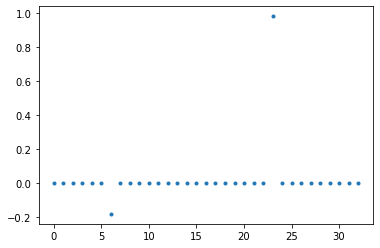

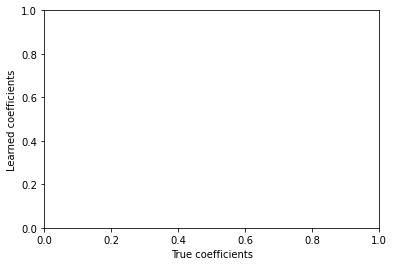

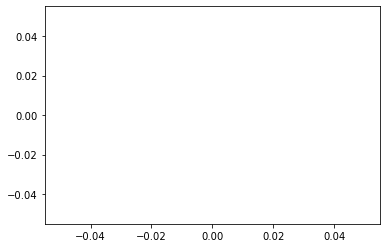

In [22]:
coef = gl.coef_[:, 1] - gl.coef_[:, 0]
plt.figure()
#plt.plot(w / np.linalg.norm(w), ".", label="True weights")
plt.plot(
    coef / np.linalg.norm(coef), ".", label="Estimated weights",
)

plt.figure()
#plt.plot([w.min(), w.max()], [coef.min(), coef.max()], "gray")
#plt.scatter(w, coef, s=10)
plt.ylabel("Learned coefficients")
plt.xlabel("True coefficients")

plt.figure()
plt.plot(gl.losses_)

plt.show()

In [63]:
groups[0:16]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])